In [1]:
import pandas as pd
import numpy as np
import regex as re

import researchpy

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import BoundaryNorm, ListedColormap

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Part 1: EDA

In [11]:
sum_df = pd.read_excel("ReviewsFR_Attributes.xlsx")

In [3]:
sum_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109275 entries, 0 to 109274
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   product_company_type_source  109275 non-null  object 
 1   retailer                     109275 non-null  object 
 2   product_category             109275 non-null  object 
 3   product_brand                109275 non-null  object 
 4   product_name                 109275 non-null  object 
 5   product_price                109270 non-null  float64
 6   review_timestamp             109275 non-null  object 
 7   review_rating                109265 non-null  float64
 8   review_title                 57150 non-null   object 
 9   review_body                  109275 non-null  object 
 10  product_rating               109250 non-null  float64
 11  product_reviews_count        109253 non-null  float64
 12  Attributes                   33898 non-null   object 
dtyp

In [13]:
# It should be noted that all relevant data is anonymized:

#sum_df["final_category"] = sum_df.product_category.map(lambda x: x.split(">")[-1].strip())

# from sklearn.preprocessing import LabelEncoder
# labelencoder = LabelEncoder()

# for col in ["product_company_type_source", "retailer", "product_category", "product_brand", "product_name"]:
#     sum_df[col] = labelencoder.fit_transform(sum_df[col])

#### 1.a - Basic Feature Engineering:

In [15]:
# Create cols:

#sum_df["final_category"] = sum_df.product_category.map(lambda x: x.split(">")[-1].strip())
# (Already executed above)

sum_df["attr_list"] = sum_df.Attributes.str.split(",")

# Drop cols:
sum_df.drop(["review_timestamp", "product_rating", "product_reviews_count", "product_price", "Attributes"], axis=1, inplace=True)

# Shorten col. name for easier use:
sum_df.rename(columns={"product_company_type_source": "company_type"}, inplace=True)

In [16]:
sum_df.head()

,company_type,retailer,product_category,product_brand,product_name,review_rating,review_title,review_body,final_category,attr_list
0,0,1,100,0,38,5.0,NaN,"Hediye olarak aldım, çok beğenildi. Teşekkür e...",Dökme Çay,NaN
1,0,1,100,0,9,5.0,NaN,Paketleme cok basarili. Çay olarak tercih etti...,Dökme Çay,"[Delivery, Recommendation]"
2,0,2,23,0,13,5.0,Makul fiyat orjinal ürün,Tam 9 yildir [PERSON_NAME] cay iciyorum.muhtes...,Çay,NaN
3,0,2,23,0,14,5.0,İkargo rezalet ve büyük sorun. Bir kargo tesli...,[LOCATION] gelmiş bir ürün ama koku ve tat ayn...,Çay,"[Smell, Taste]"
4,0,1,100,0,26,5.0,Beş Yıldız,"Çay için özel zevkleri olanlara ideal,güzelce ...",Dökme Çay,[Recommendation]


### Part 2: Main Feature Engineering & creating .gropby() columns:

In [79]:
# 1- Brand Review Count:

br_rev_count = sum_df.groupby("product_brand")["review_body"].count().sort_values(ascending=False)
print(br_rev_count[:10])

product_brand
27    32150
16    31614
17     8038
7      6839
14     5422
1      4441
25     3390
15     2910
2      2274
11     2153
Name: review_body, dtype: int64


In [80]:
# 2- Product Review Count:

pr_rew_count = sum_df.groupby("product_name")["review_body"].count().sort_values(ascending=False)
print(pr_rew_count[:10])

product_name
2728    10839
2696     4705
1901     2952
1620     2506
1228     2093
1759     1892
1628     1778
1852     1669
1324     1655
1937     1637
Name: review_body, dtype: int64


In [19]:
# 2.5 Create "product_reviews_count" manually:
sum_df = sum_df.merge(pr_rew_count.to_frame(), how="left", left_on="product_name", right_index=True)

sum_df.rename(columns={"review_body_x": "review_body", "review_body_y":"product_reviews_count"}, inplace=True)

In [20]:
sum_df.head()

,company_type,retailer,product_category,product_brand,product_name,review_rating,review_title,review_body,final_category,attr_list,product_reviews_count
0,0,1,100,0,38,5.0,NaN,"Hediye olarak aldım, çok beğenildi. Teşekkür e...",Dökme Çay,NaN,43
1,0,1,100,0,9,5.0,NaN,Paketleme cok basarili. Çay olarak tercih etti...,Dökme Çay,"[Delivery, Recommendation]",69
2,0,2,23,0,13,5.0,Makul fiyat orjinal ürün,Tam 9 yildir [PERSON_NAME] cay iciyorum.muhtes...,Çay,NaN,4
3,0,2,23,0,14,5.0,İkargo rezalet ve büyük sorun. Bir kargo tesli...,[LOCATION] gelmiş bir ürün ama koku ve tat ayn...,Çay,"[Smell, Taste]",4
4,0,1,100,0,26,5.0,Beş Yıldız,"Çay için özel zevkleri olanlara ideal,güzelce ...",Dökme Çay,[Recommendation],2


In [21]:
# 3- Retailer Review Count:

sum_df.groupby("retailer")["review_body"].count().sort_values(ascending=False)

retailer
1    101753
2      5163
3      2317
0        22
4        20
Name: review_body, dtype: int64

In [22]:
# Product Category Count:
sum_df.groupby("final_category")["review_body"].count().sort_values(ascending=False)

final_category
Dökme Çay                                             52762
Demlik Poşet Çay                                      14198
Bitki Çayı                                             9538
Bardak Poşet Çay                                       4161
Baharat                                                3540
                                                      ...  
Süt                                                       1
Karali Hediyelik Çay 1 Kg                                 1
Karali Premium Bergamotlu Bardak Poşet Çay 2G 20Ad        1
Karali Premium Siyah Bardak Poşet Çay 2 Gr 20 Adet        1
Fındık                                                    1
Name: review_body, Length: 96, dtype: int64

### Part 3: Creating Pivot Tables:

The attr. pivot tables needs to be:

1) .dropna() empty attribute rows
2) .explode() for multiple attr.s



In [23]:
attr_df = sum_df.copy()

In [24]:
attr_df.head()

,company_type,retailer,product_category,product_brand,product_name,review_rating,review_title,review_body,final_category,attr_list,product_reviews_count
0,0,1,100,0,38,5.0,NaN,"Hediye olarak aldım, çok beğenildi. Teşekkür e...",Dökme Çay,NaN,43
1,0,1,100,0,9,5.0,NaN,Paketleme cok basarili. Çay olarak tercih etti...,Dökme Çay,"[Delivery, Recommendation]",69
2,0,2,23,0,13,5.0,Makul fiyat orjinal ürün,Tam 9 yildir [PERSON_NAME] cay iciyorum.muhtes...,Çay,NaN,4
3,0,2,23,0,14,5.0,İkargo rezalet ve büyük sorun. Bir kargo tesli...,[LOCATION] gelmiş bir ürün ama koku ve tat ayn...,Çay,"[Smell, Taste]",4
4,0,1,100,0,26,5.0,Beş Yıldız,"Çay için özel zevkleri olanlara ideal,güzelce ...",Dökme Çay,[Recommendation],2


In [25]:
attr_df.dropna(subset="attr_list", inplace=True)

attr_df = attr_df.explode("attr_list", ignore_index=True)

Need to crate a flexible heatmap function that can be used to compare products based on their company type.

The heatmap needs to have 3 color ranges based on the average score of the category:

- Red: if the average score is lower than 4 (<4)
- Yellow: if the average score is between 4 - 4.5
- Green: if the average score is above 4.5

In [26]:
# Heatmap Function:

def draw_heatmap(df,legend,figsize=(20,14)):

    my_colors = ['darkred', 'orange', 'green']
    my_cmap = ListedColormap(my_colors)
    bounds = [0, 4, 4.50, 5]
    my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))

    if legend == "vertical":
        f, ax = plt.subplots(1,1, figsize=figsize)

        sns.color_palette()
        ax = sns.heatmap(df, square=True, annot=True, linewidth=0.3, ax=ax, annot_kws={"fontsize":15},
                cmap=my_cmap,
                norm=my_norm)

        ax.set_xlabel("")
        ax.set_ylabel("")

        colorbar = ax.collections[0].colorbar
        colorbar.set_ticks([4,4.5,5])
        colorbar.set_ticklabels(['Low','Med','High'])


    elif legend == "horizontal":
        grid_kws = {"height_ratios": (.95, .05)}
        f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=figsize)

        sns.color_palette()
        ax = sns.heatmap(df, square=True, annot=True, linewidth=0.3, ax=ax, annot_kws={"fontsize":15},
                cbar_ax=cbar_ax,
                cmap=my_cmap,
                norm=my_norm,
                cbar_kws={"orientation": "horizontal"})

        ax.set_xlabel("")
        ax.set_ylabel("")

        colorbar = ax.collections[0].colorbar
        colorbar.set_ticks([4,4.5,5])
        colorbar.set_ticklabels(['Low','Med','High'])

    elif legend==False:
        f, ax = plt.subplots(1,1, figsize=figsize)

        my_colors = ['darkred', 'orange', 'green']
        my_cmap = ListedColormap(my_colors)
        bounds = [0, 4, 4.50, 5]
        my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))

        sns.color_palette()
        ax = sns.heatmap(df, square=True, annot=True, linewidth=0.3, ax=ax, annot_kws={"fontsize":15},
                        cbar =False,
                        cmap=my_cmap,
                        norm=my_norm)

        ax.set_xlabel("")
        ax.set_ylabel("")


    plt.show()


### 3.1 - Own(1) vs. Competition(0) Attribute Comparison

In [30]:
own_brands = attr_df[attr_df.company_type == 1]["product_brand"].unique()

In [33]:
attr_df.head()

,company_type,retailer,product_category,product_brand,product_name,review_rating,review_title,review_body,final_category,attr_list,product_reviews_count
0,0,1,100,0,9,5.0,NaN,Paketleme cok basarili. Çay olarak tercih etti...,Dökme Çay,Delivery,69
1,0,1,100,0,9,5.0,NaN,Paketleme cok basarili. Çay olarak tercih etti...,Dökme Çay,Recommendation,69
2,0,2,23,0,14,5.0,İkargo rezalet ve büyük sorun. Bir kargo tesli...,[LOCATION] gelmiş bir ürün ama koku ve tat ayn...,Çay,Smell,4
3,0,2,23,0,14,5.0,İkargo rezalet ve büyük sorun. Bir kargo tesli...,[LOCATION] gelmiş bir ürün ama koku ve tat ayn...,Çay,Taste,4
4,0,1,100,0,26,5.0,Beş Yıldız,"Çay için özel zevkleri olanlara ideal,güzelce ...",Dökme Çay,Recommendation,2


In [41]:
own_comp_attr_pivot = pd.pivot_table(data=attr_df, columns="attr_list", index="company_type", values="review_rating").rename(index={0:"Competitor", 1: "Own"})

__Table__

In [42]:
own_comp_attr_pivot.round(2)

attr_list,Authenticity,Color,Consistence,Delivery,Expire Date,Flocculation,Ingredient,Packaging,Price,Quality,Recommendation,Satisfaction,Smell,Taste
company_type,,,,,,,,,,,,,,
Competitor,4.79,4.42,4.41,4.79,4.56,2.83,4.54,4.43,4.78,4.79,4.78,4.72,4.27,4.51
Own,4.86,4.37,4.30,4.77,4.52,4.20,4.08,4.38,4.77,4.69,4.71,4.77,4.38,4.47


__Heatmap__

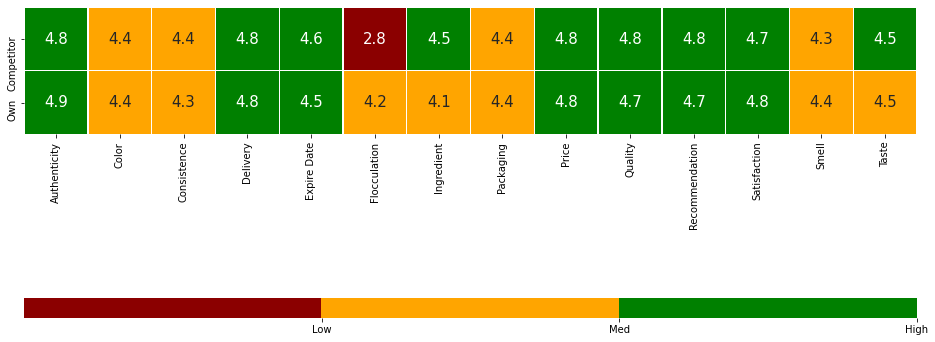

In [43]:
draw_heatmap(own_comp_attr_pivot,legend="horizontal", figsize=(16,8))

### 3.2 - Brands Attribute Comparison

In [44]:
brand_attr_pivot = pd.pivot_table(data=attr_df[attr_df.attr_list != "Flocculation"], columns="attr_list", index="product_brand", values="review_rating")

__Table__

In [45]:
brand_attr_pivot.round(2)

attr_list,Authenticity,Color,Consistence,Delivery,Expire Date,Ingredient,Packaging,Price,Quality,Recommendation,Satisfaction,Smell,Taste
product_brand,,,,,,,,,,,,,
0,4.36,4.40,4.00,4.34,3.88,NaN,3.90,3.96,4.62,4.77,4.26,3.98,4.10
1,4.73,NaN,4.00,4.86,4.82,3.62,4.59,4.83,4.85,4.87,4.82,4.57,4.47
2,5.00,4.46,NaN,4.80,4.50,5.00,4.15,4.73,4.73,4.80,4.79,4.17,4.42
3,NaN,NaN,NaN,4.78,5.00,NaN,NaN,5.00,5.00,4.67,NaN,NaN,4.91
4,NaN,NaN,NaN,4.86,NaN,NaN,4.75,4.75,5.00,5.00,4.67,NaN,4.50
5,4.80,NaN,4.14,4.74,4.27,3.00,4.33,4.76,4.87,4.76,4.82,4.00,4.49
6,4.38,4.17,4.00,4.64,4.50,4.33,4.55,4.75,4.71,4.77,4.45,4.67,4.51
7,4.83,4.39,4.42,4.69,4.45,4.40,4.29,4.62,4.65,4.61,4.58,4.34,4.40
8,5.00,NaN,5.00,4.83,4.50,NaN,5.00,4.84,4.72,4.58,4.88,4.30,4.75


__Heatmap__

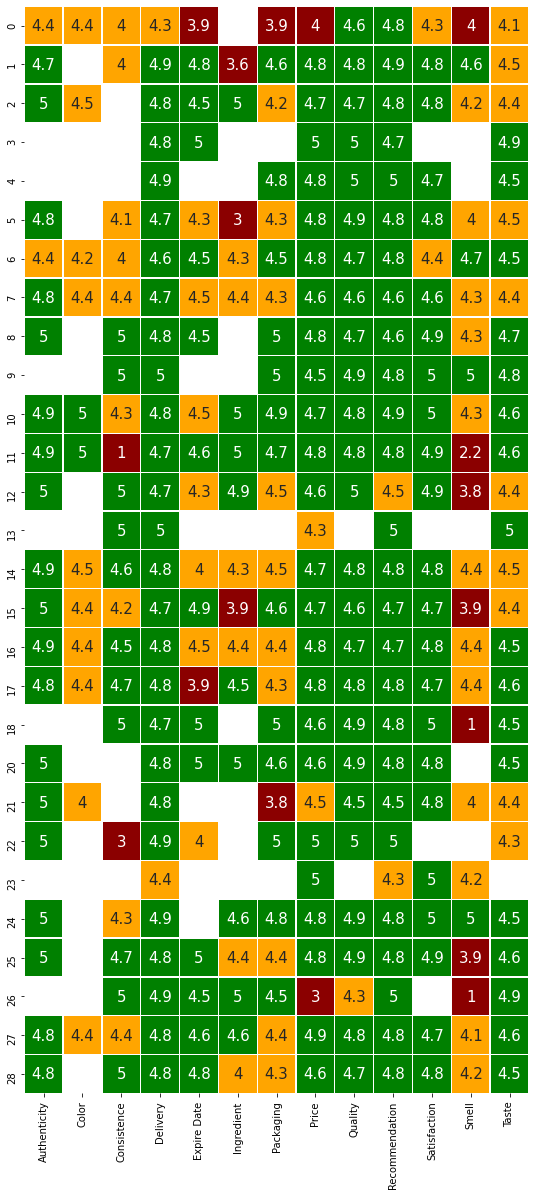

In [46]:
draw_heatmap(brand_attr_pivot,legend=False, figsize=(30,20))

__Own Brands Heatmap__

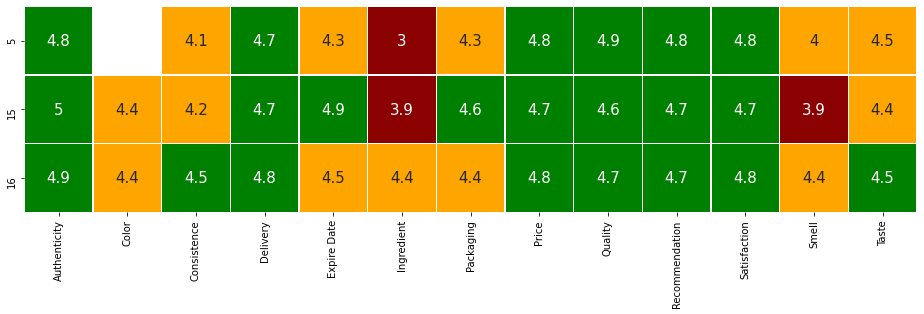

In [47]:
draw_heatmap(brand_attr_pivot.loc[own_brands],legend=False, figsize=(16,9))

__Table (> 100 Product Reviews)__

In [48]:
# Brand vs Attribute Table (>100 product reviews)
brand_attr_pivot100 = pd.pivot_table(data=attr_df[(attr_df.product_reviews_count > 100) & (attr_df.attr_list != "Flocculation")], columns="attr_list", index="product_brand", values="review_rating")

### 3.3 - SKU Attribute Comparison

__Table__

In [49]:
# SKU vs Attribute Table
sku_attr_pivot = pd.pivot_table(data=attr_df, columns="attr_list", index="product_name", values="review_rating")

__Table (> 100 Product Reviews)__

In [50]:
# SKU vs Attribute Table (>100 product reviews)
sku_attr_pivot100 = pd.pivot_table(data=attr_df[(attr_df.product_reviews_count > 100) & (attr_df.attr_list != "Flocculation")], columns="attr_list", index="product_name", values="review_rating")

__Table (> 500 Product Reviews)__

In [51]:
# SKU vs Attribute Table (>500 product reviews)

sku_attr_pivot500 = pd.pivot_table(data=attr_df[(attr_df.product_reviews_count > 500) & (attr_df.attr_list != "Flocculation")], columns="attr_list", index="product_name", values="review_rating")

### Part 4: Welsh's t-test & Effect Size 

All the brand & product reviews in the dataset can be compared to their own category to analyse if they are significantly different than the category average, based on Welsh's t-test & effect size.

The function below can be used for both:

In [52]:
# df: dataframe
# mode: "brand" OR "SKU"
# name: SKU OR brand name

def brand_vs_categ(df, mode, name):
    if mode == "brand":
        all_categs = df[df.product_brand == name]["final_category"].unique()
        brand_mask = df.product_brand == name
        categ_mask = df.final_category.isin(all_categs)
    elif mode == "SKU":
        all_categs = df[df.product_name == name]["final_category"].unique()
        brand_mask = df.product_name == name
        categ_mask = df.final_category.isin(all_categs)

    print(f'{name} - Avg. Score: {round(df[brand_mask]["review_rating"].mean(),2)}')
    print(f'Category - Avg. Score: {round(df[categ_mask]["review_rating"].mean(),2)}')


    des, res = researchpy.ttest(df[brand_mask]["review_rating"], df[categ_mask]["review_rating"],
                            equal_variances= False)
    

    p_value = res.loc[3,"results"]
    effect_size = abs(res.loc[6,"results"])

    brand_mean = des.loc[0,"Mean"]
    category_mean = des.loc[1,"Mean"]

    if (p_value <.05) & (effect_size > .2):
        if brand_mean > category_mean:
            result = "Stronger"
        else:
            result = "Weaker"
    else:
        result = "Parity"
    
    print(f"\nT-test & effect size result: {result}")
    
    if mode == "brand":
        brand_group = attr_df[attr_df.product_brand == name].groupby("attr_list")["review_rating"].mean()
        categ_group = attr_df[attr_df.final_category.isin(all_categs)].groupby("attr_list")["review_rating"].mean()
    elif mode == "SKU":
        brand_group = attr_df[attr_df.product_name == name].groupby("attr_list")["review_rating"].mean()
        categ_group = attr_df[attr_df.final_category.isin(all_categs)].groupby("attr_list")["review_rating"].mean()

    pivot_table = pd.concat([brand_group,categ_group], axis=1,keys=[name,"Category"]).transpose()
    draw_heatmap(pivot_table, legend=False, figsize=(16,9))
    
    

__Own Brands__

5 - Avg. Score: 4.67
Category - Avg. Score: 4.71

T-test & effect size result: Parity


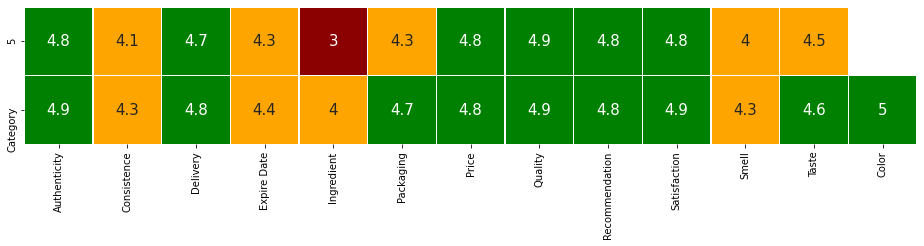

In [53]:
brand_vs_categ(attr_df,"brand",5)

15 - Avg. Score: 4.45
Category - Avg. Score: 4.63

T-test & effect size result: Weaker


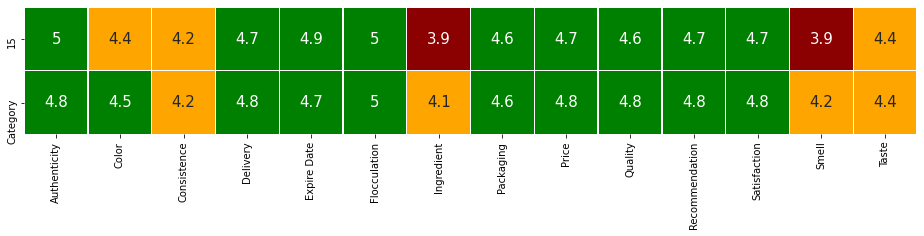

In [54]:
brand_vs_categ(attr_df,"brand",15)

16 - Avg. Score: 4.66
Category - Avg. Score: 4.68

T-test & effect size result: Parity


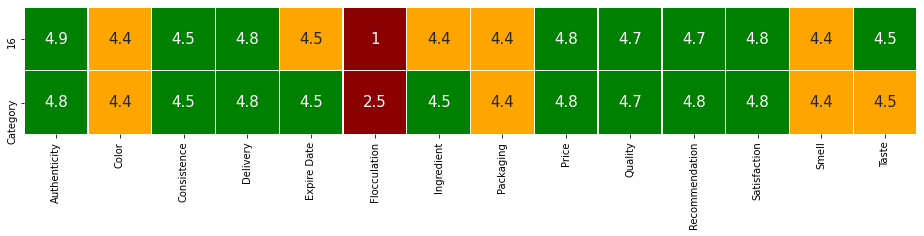

In [55]:
brand_vs_categ(attr_df,"brand",16)

__SKU Mode:__

16 - Avg. Score: 3.29
Category - Avg. Score: 4.71

T-test & effect size result: Weaker


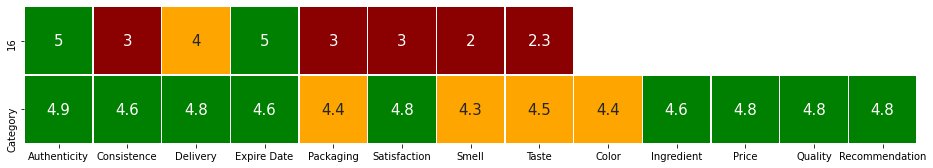

In [61]:
brand_vs_categ(attr_df,"SKU",16)

23 - Avg. Score: 2.67
Category - Avg. Score: 4.62

T-test & effect size result: Parity


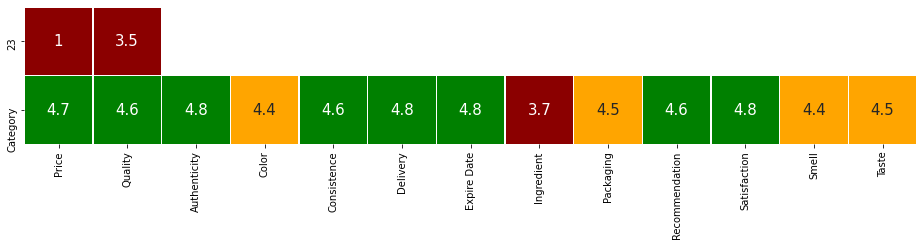

In [65]:
brand_vs_categ(attr_df,"SKU",23)

### Part 5: Single SKU & Brand Graphs: 

In [66]:
# Heatmap Function:

# df: dataframe
# mode: "SKU" or "brand"
# figsize: graph size
# vertical: vertical if True 
# all_categs: displays all categories if True (even if the brand/SKU does not have any reviews in that category)
# annot: displays the category average if True

def single_heatmap(df, mode, name, figsize=(16,8), vertical=False, all_categs=False, annot=False):

    if mode == "SKU":
        heat_df = df[df.product_name == name].groupby("attr_list")["review_rating"].mean().sort_values(ascending=False).to_frame().transpose()
        
        count_df = df[df.product_name == name].groupby("attr_list")["review_rating"].count().to_frame().transpose()
        count_sum = count_df.sum(axis=1)[0]
        count_df = count_df/count_sum  * 100
        
        print(f'{name} - Avg. Score: {round(df[df.product_name == name]["review_rating"].mean(),2)}')
        print(f"{name} Total Comments: {count_sum}")



    elif mode == "brand":
        heat_df = df[df.product_brand == name].groupby("attr_list")["review_rating"].mean().sort_values(ascending=False).to_frame().transpose()
        
        count_df = df[df.product_brand == name].groupby("attr_list")["review_rating"].count().to_frame().transpose()
        count_sum = count_df.sum(axis=1)[0]
        count_df = round(count_df/count_sum * 100, 1)


        print(f'{name} - Avg. Score: {round(df[df.product_brand == name]["review_rating"].mean(),2)}')
        print(f"{name} Total Comments: {count_sum}")


    if all_categs == True:
        columns_df = pd.DataFrame(columns=df.attr_list.unique())
        heat_df = pd.concat([columns_df,heat_df])
        count_df = pd.concat([columns_df,count_df])

    else:
        col_order = heat_df.columns.tolist()
        count_df = count_df.loc[:,col_order]


    if vertical == True:
        heat_df = heat_df.transpose()
        count_df = count_df.transpose()
        nrows, ncols = 1,2
        figsize = (figsize[1],figsize[0])
    else:
        nrows, ncols = 2,1
    
    f, (ax1,ax2) = plt.subplots(nrows, ncols, figsize=figsize)

    my_colors = ['darkred', 'orange', 'green']
    my_cmap = ListedColormap(my_colors)
    bounds = [0, 4, 4.50, 5]
    my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))

    my_colors2 = ['lightskyblue', 'skyblue', 'deepskyblue', 'steelblue']
    my_norm2 = BoundaryNorm([0,10,20,23,50],ncolors=4)

    sns.color_palette()
    ax1 = sns.heatmap(heat_df, square=True, annot=annot, linewidth=0.1, ax=ax1, annot_kws={"fontsize":12},
                    cbar =False,
                    cmap=my_cmap,
                    norm=my_norm)
    
    ax1.set_title(name, fontdict={'fontsize': 15}, pad=10)
    ax1.set_xlabel("")
    ax1.set_ylabel("")
        

    ax2 = sns.heatmap(count_df, square=True, annot=annot, linewidth=0.1, ax=ax2, annot_kws={"fontsize":15}, cbar=False,cmap=my_colors2,  norm=my_norm2)
    ax2.set_title(f"{name} Comment Percentages (%):", fontdict={'fontsize': 15}, pad=10)
    ax2.set_xlabel("")
    ax2.set_ylabel("")
    

    if vertical == True:
        ax1.get_xaxis().set_visible(False)
        ax2.get_xaxis().set_visible(False)
        
    else:
        ax1.get_yaxis().set_visible(False)
        ax2.get_yaxis().set_visible(False)
    
    plt.show()

    


__Brand Mode:__

15 - Avg. Score: 4.45
15 Total Comments: 1920


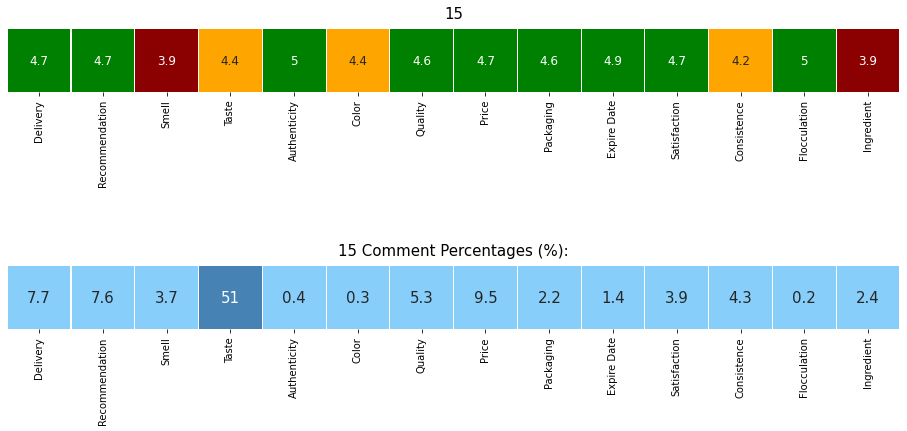

In [67]:
single_heatmap(attr_df, mode="brand", name=15, vertical=False, annot=True, all_categs=True)

__SKU Mode:__

14 - Avg. Score: 5.0
14 Total Comments: 4


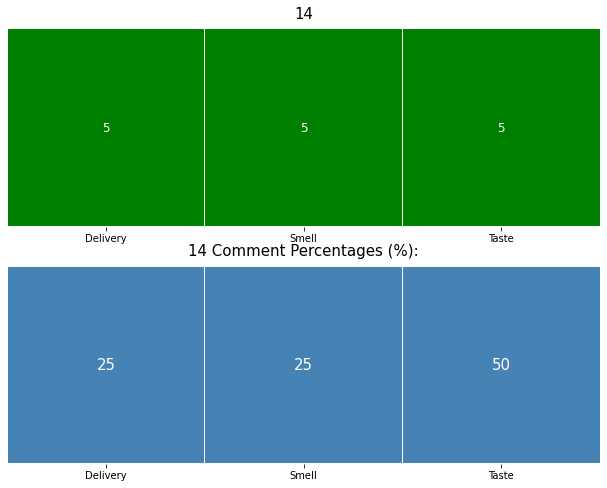

In [69]:
single_heatmap(attr_df, mode="SKU", name=14, annot=True, all_categs=False)

16 - Avg. Score: 3.29
16 Total Comments: 14


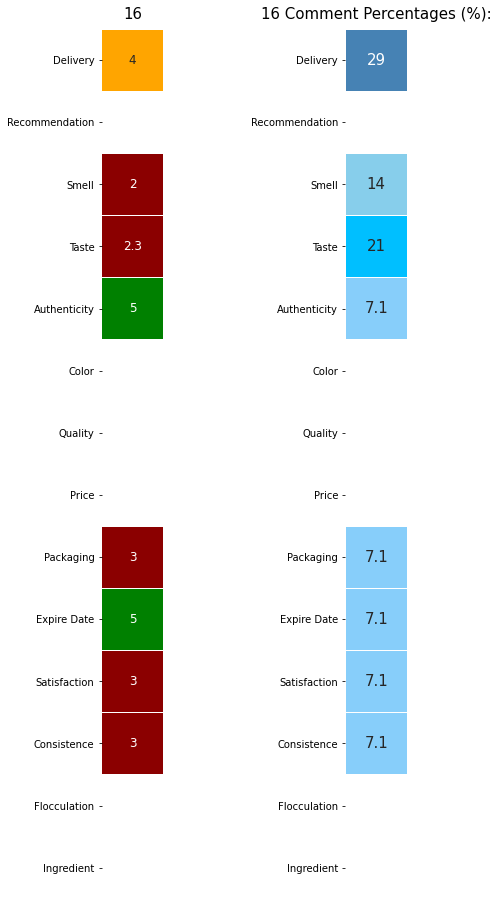

In [72]:
single_heatmap(attr_df, mode="SKU", name=16, annot=True, all_categs=True, vertical=True)

__Unilever SKUs with > 500 reviews:__

In [75]:
ul_sku500 = attr_df[(attr_df.product_reviews_count >500) & (attr_df.company_type == 1)]["product_name"].unique().tolist()

1409 - Avg. Score: 4.37
1409 Total Comments: 1051


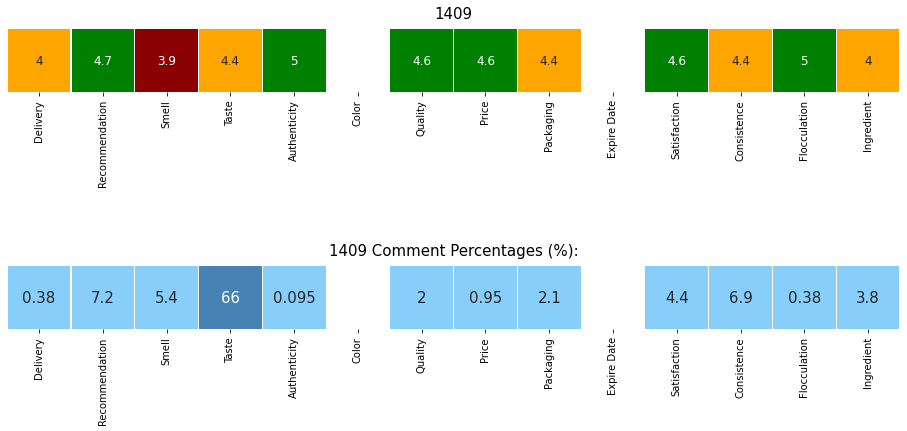

1793 - Avg. Score: 4.84
1793 Total Comments: 593


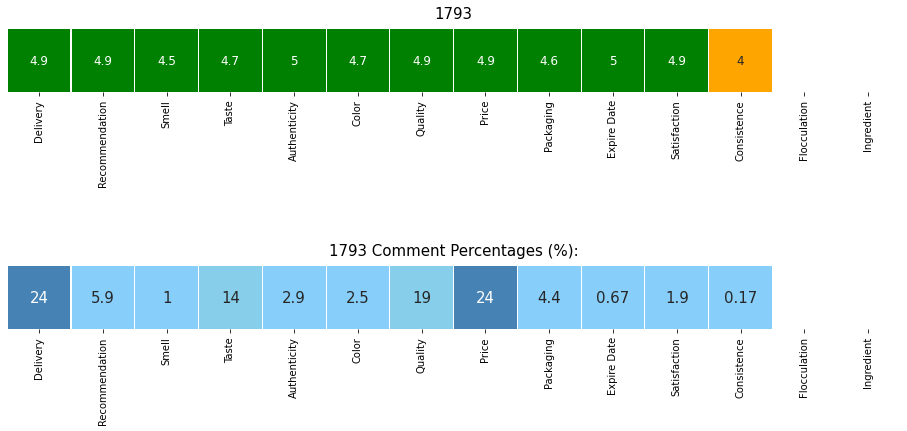

1628 - Avg. Score: 4.82
1628 Total Comments: 865


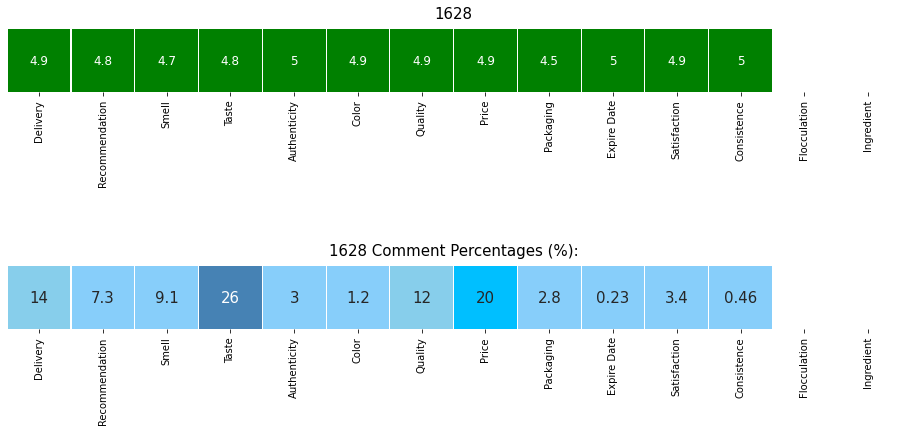

2410 - Avg. Score: 4.8
2410 Total Comments: 606


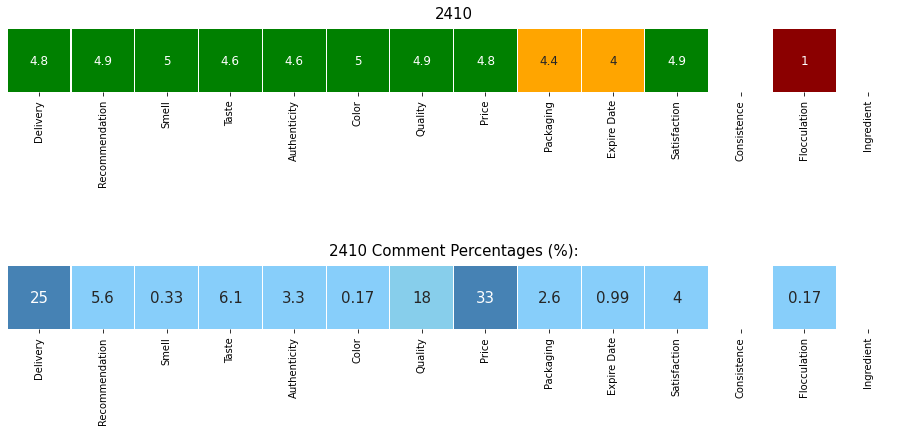

1592 - Avg. Score: 4.68
1592 Total Comments: 278


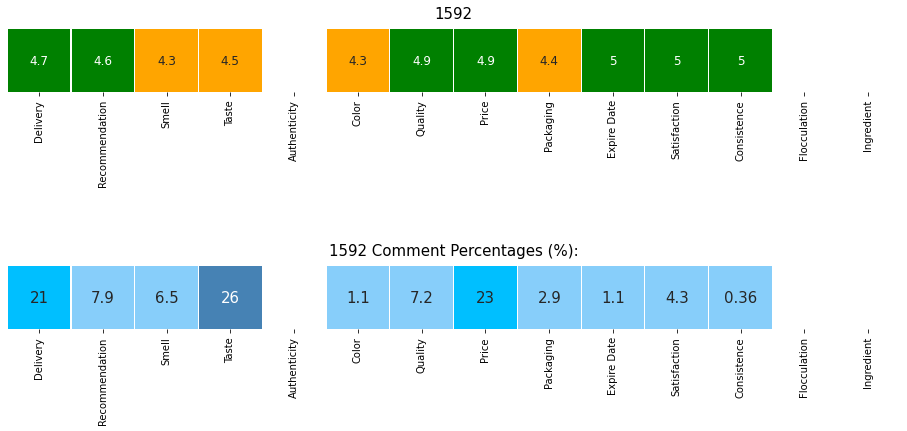

1620 - Avg. Score: 4.73
1620 Total Comments: 841


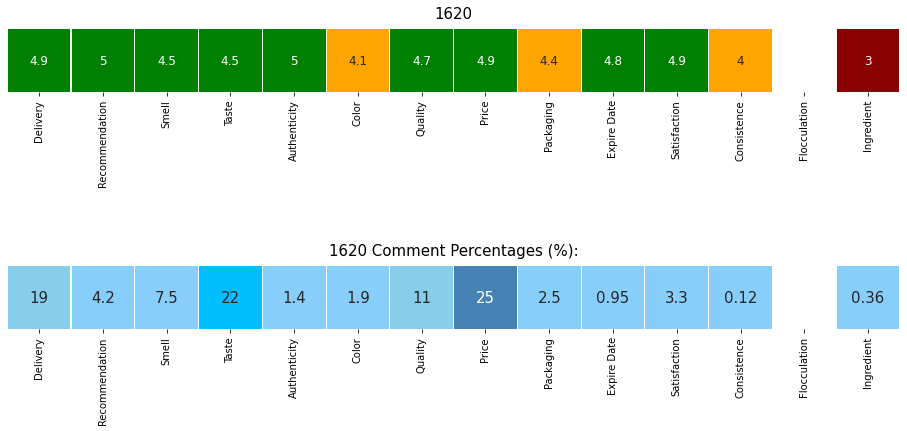

1852 - Avg. Score: 4.71
1852 Total Comments: 920


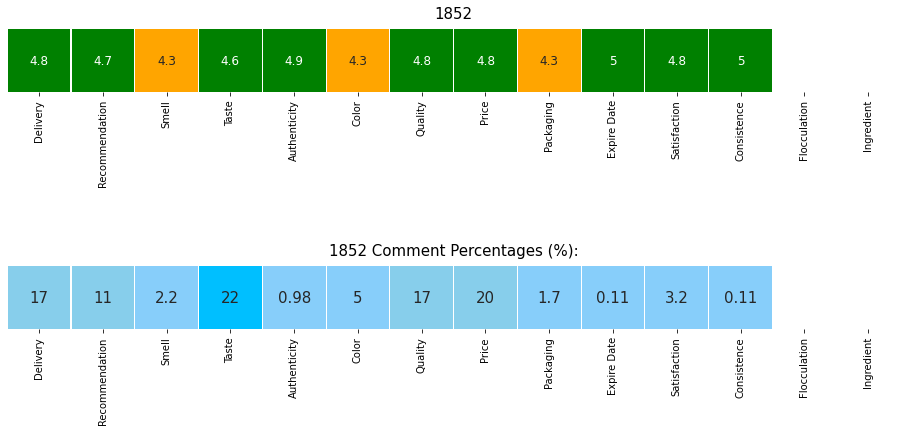

1568 - Avg. Score: 4.82
1568 Total Comments: 373


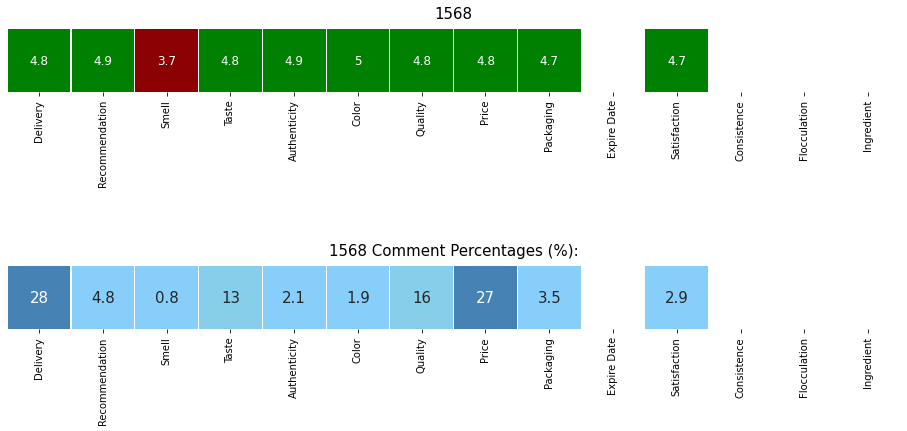

1645 - Avg. Score: 4.67
1645 Total Comments: 398


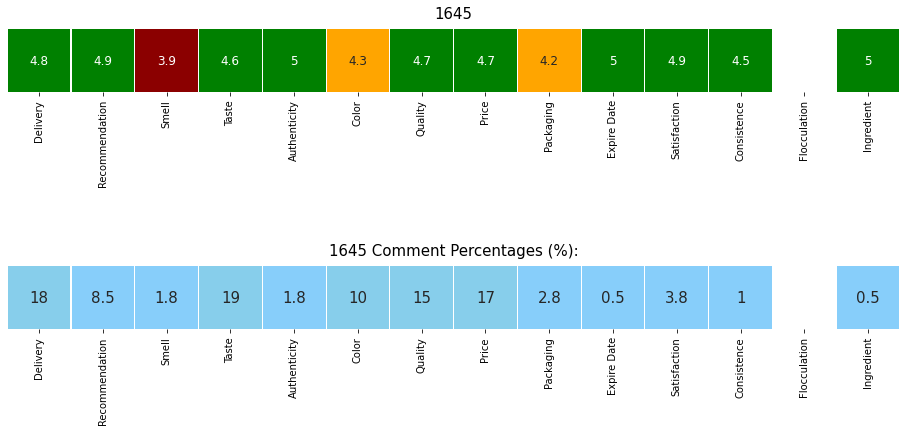

1759 - Avg. Score: 4.39
1759 Total Comments: 801


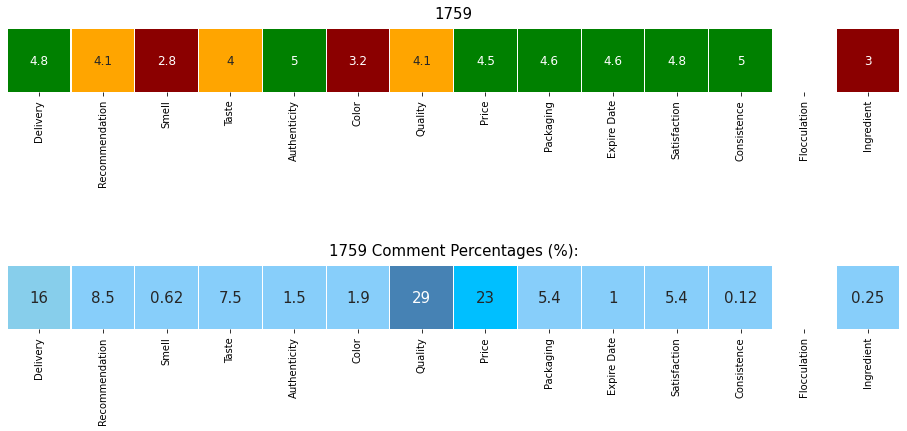

1813 - Avg. Score: 4.46
1813 Total Comments: 541


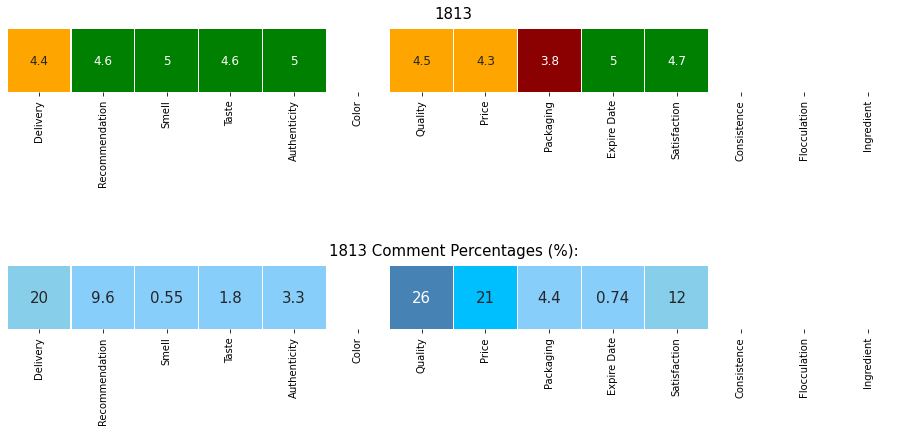

6 - Avg. Score: 4.6
6 Total Comments: 369


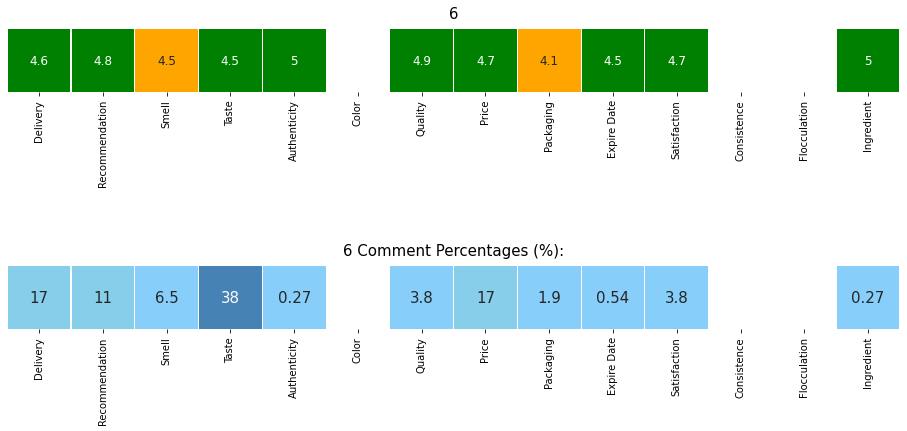

1786 - Avg. Score: 4.82
1786 Total Comments: 195


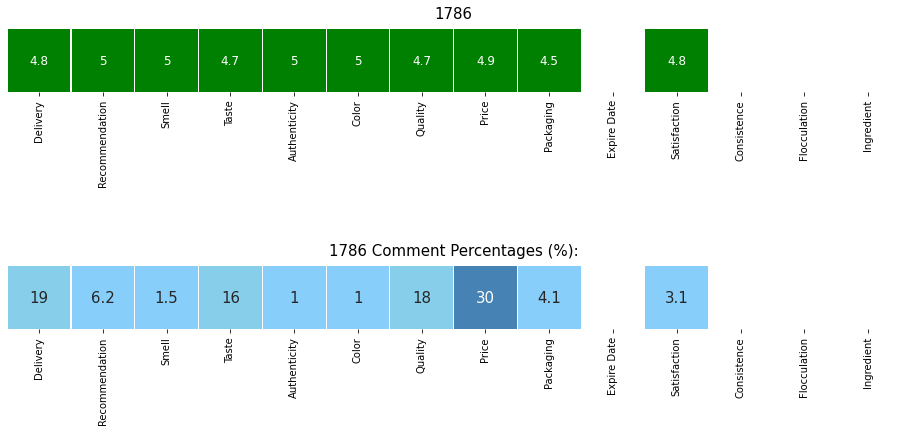

1661 - Avg. Score: 4.73
1661 Total Comments: 368


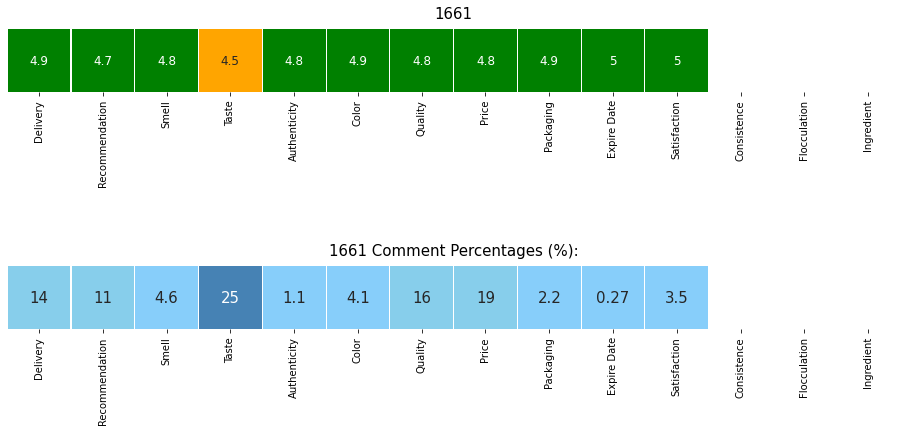

1778 - Avg. Score: 4.77
1778 Total Comments: 187


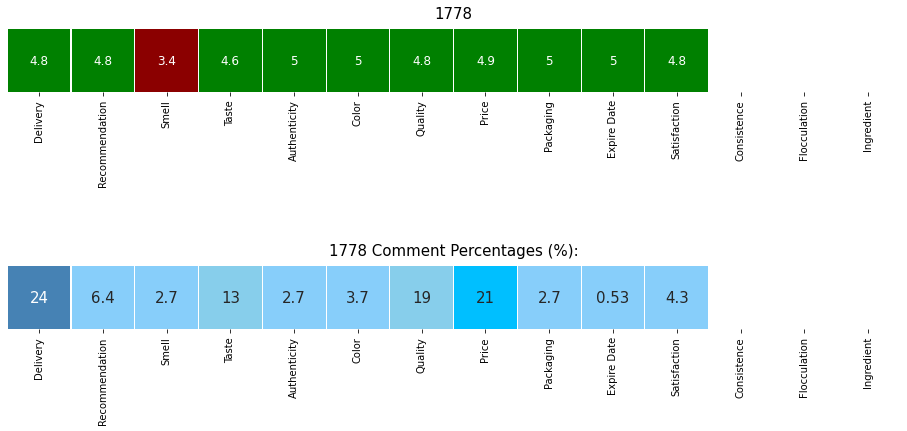

1643 - Avg. Score: 4.81
1643 Total Comments: 302


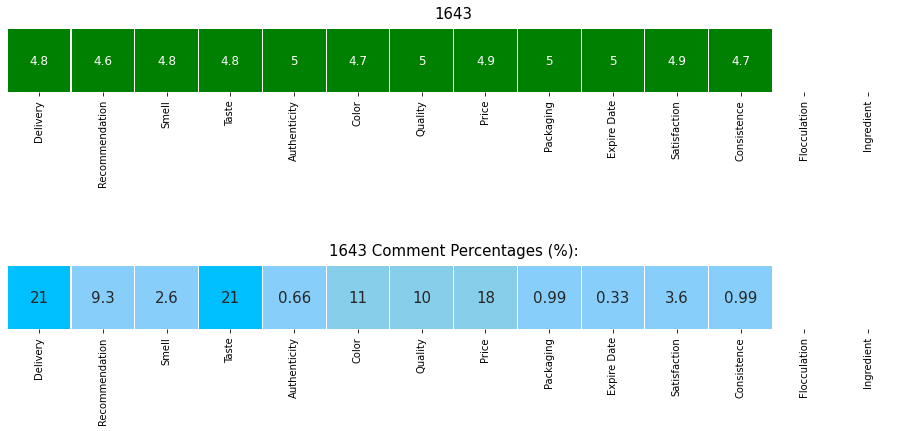

1529 - Avg. Score: 4.58
1529 Total Comments: 177


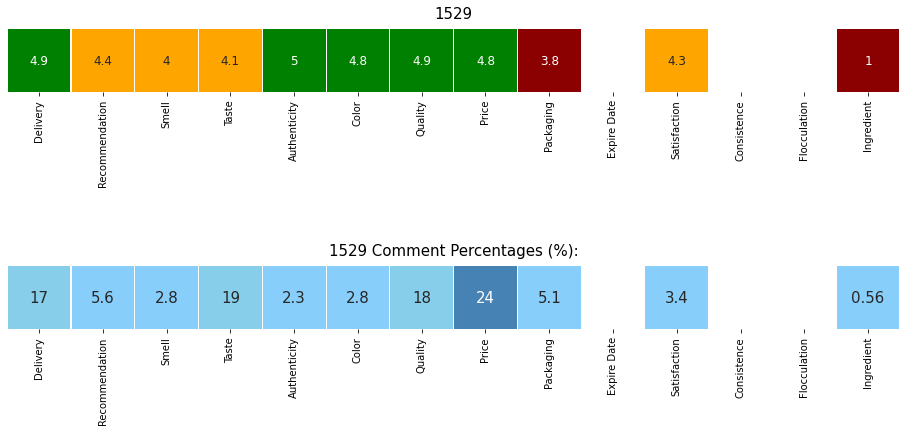

In [77]:
for sku in ul_sku500:
    single_heatmap(attr_df, mode="SKU", name=sku, vertical=False, annot=True, all_categs=True)

1409 - Avg. Score: 4.37
1409 Total Comments: 1051


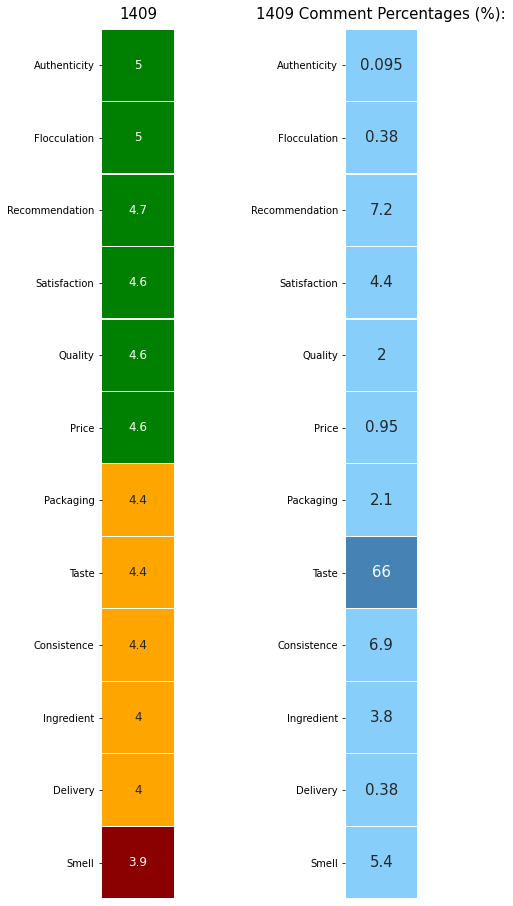

1793 - Avg. Score: 4.84
1793 Total Comments: 593


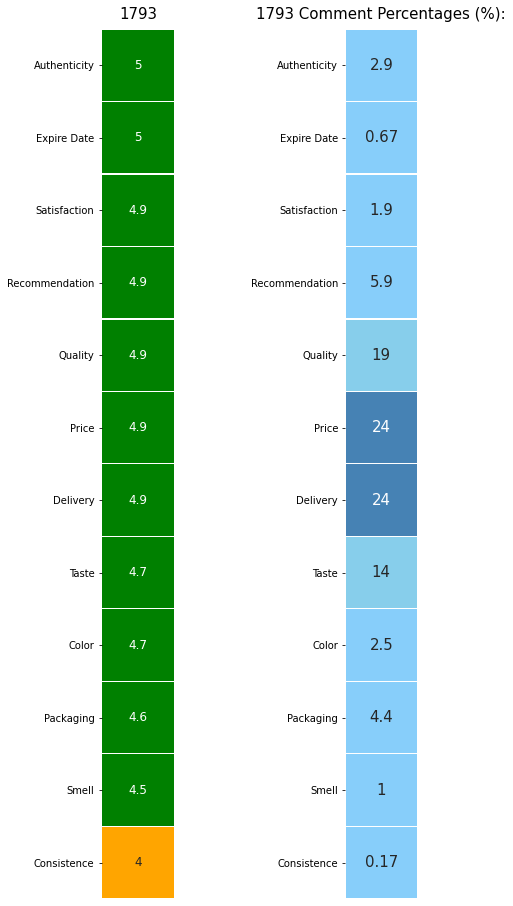

1628 - Avg. Score: 4.82
1628 Total Comments: 865


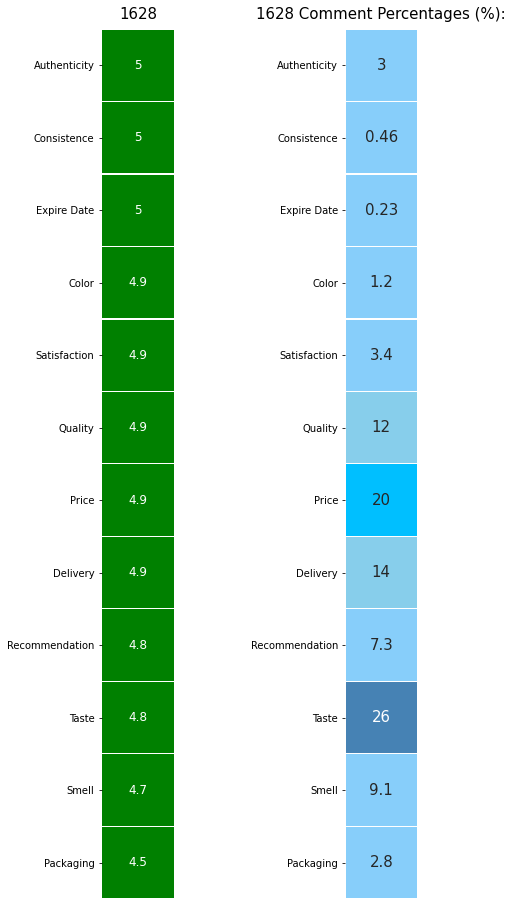

2410 - Avg. Score: 4.8
2410 Total Comments: 606


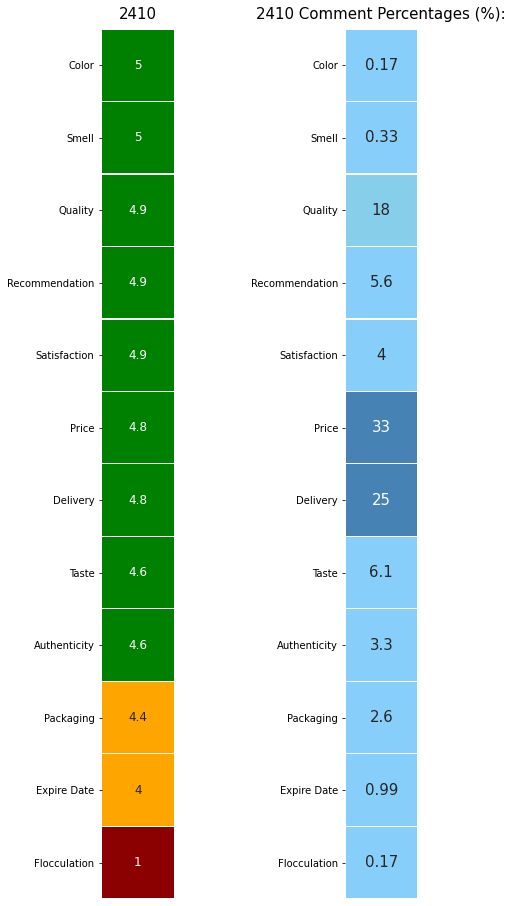

1592 - Avg. Score: 4.68
1592 Total Comments: 278


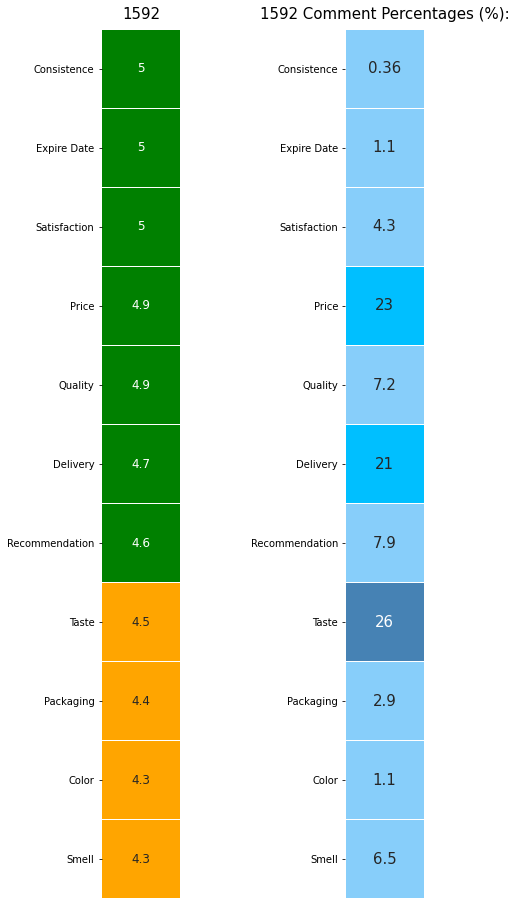

1620 - Avg. Score: 4.73
1620 Total Comments: 841


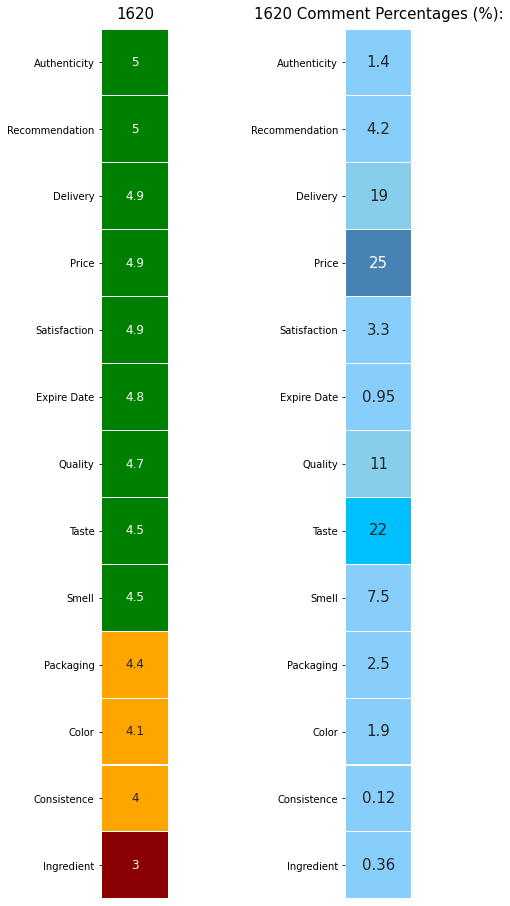

1852 - Avg. Score: 4.71
1852 Total Comments: 920


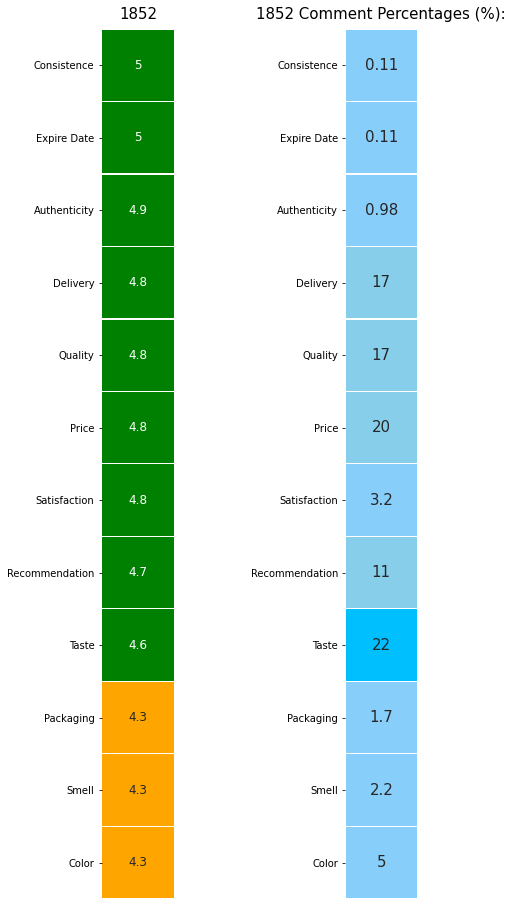

1568 - Avg. Score: 4.82
1568 Total Comments: 373


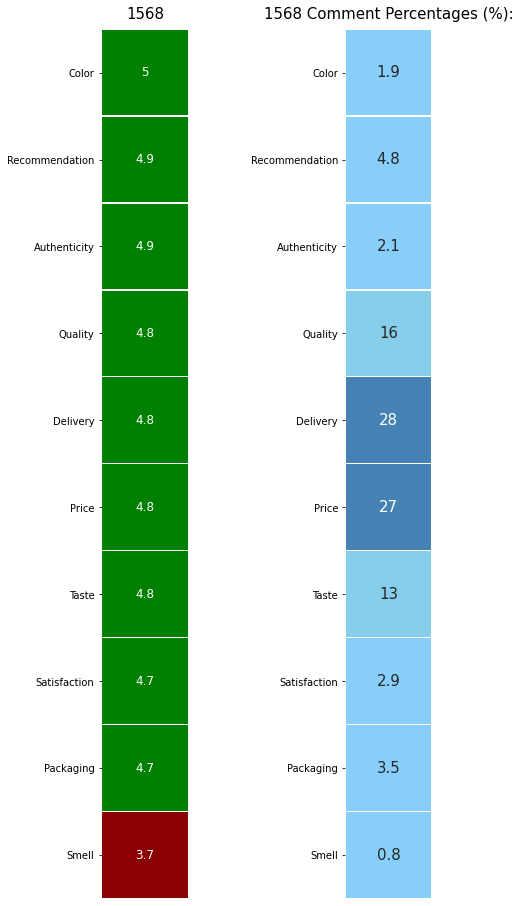

1645 - Avg. Score: 4.67
1645 Total Comments: 398


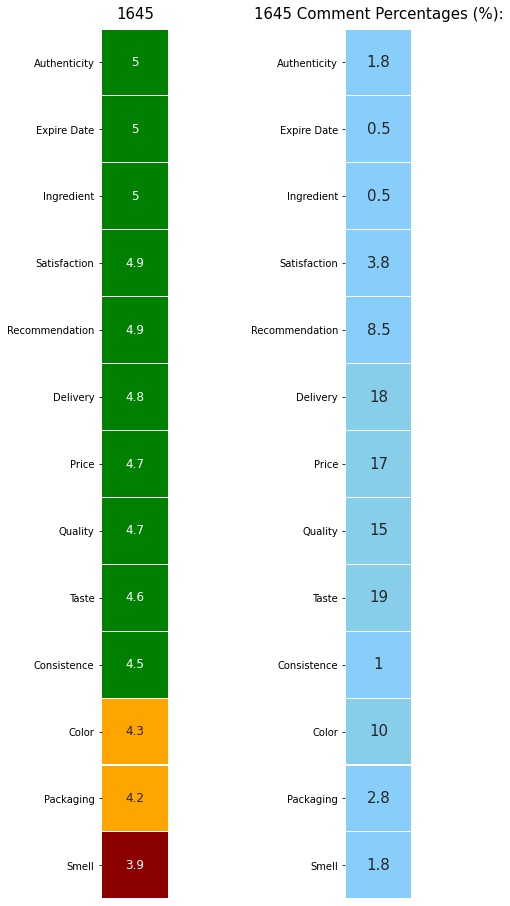

1759 - Avg. Score: 4.39
1759 Total Comments: 801


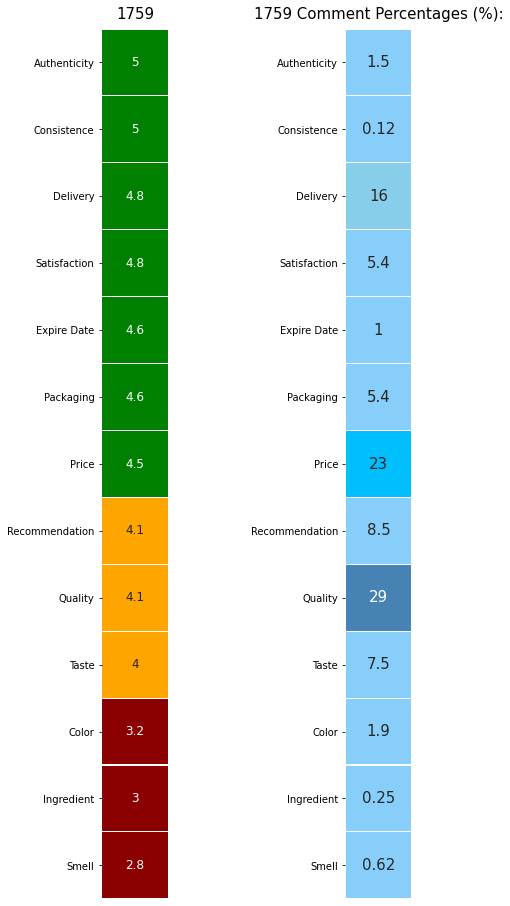

1813 - Avg. Score: 4.46
1813 Total Comments: 541


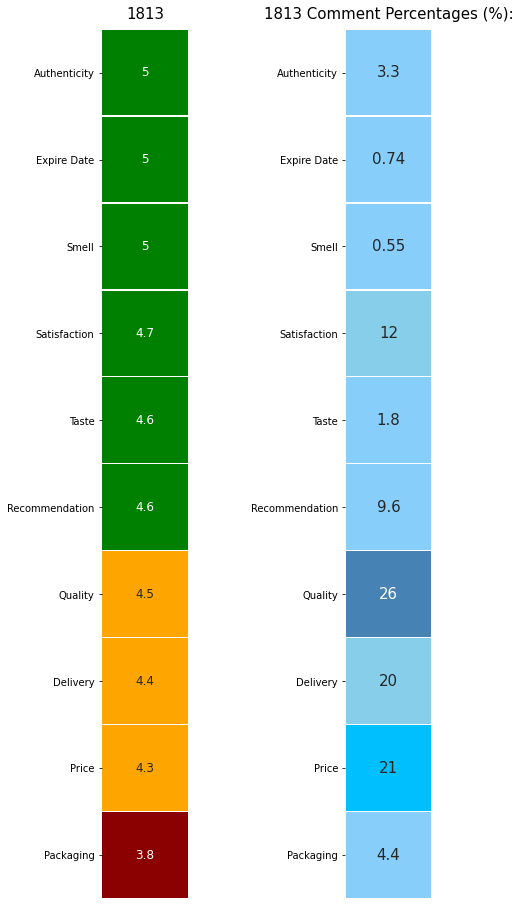

6 - Avg. Score: 4.6
6 Total Comments: 369


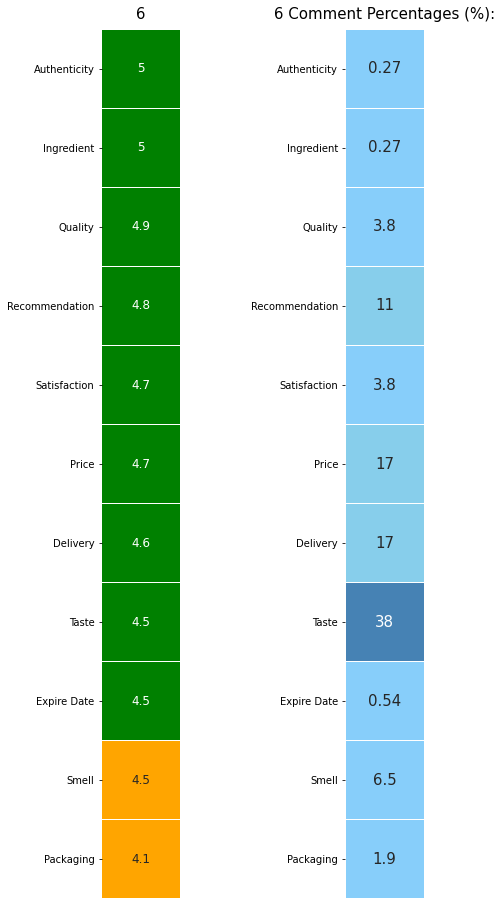

1786 - Avg. Score: 4.82
1786 Total Comments: 195


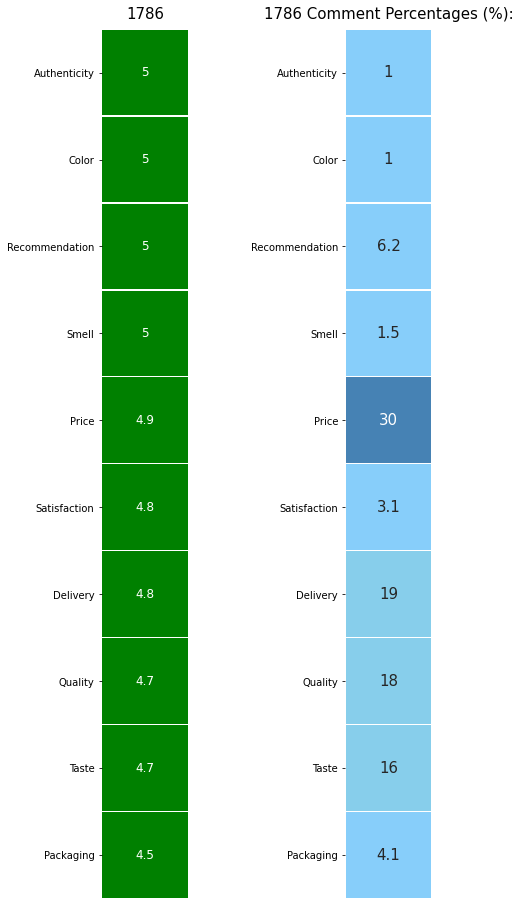

1661 - Avg. Score: 4.73
1661 Total Comments: 368


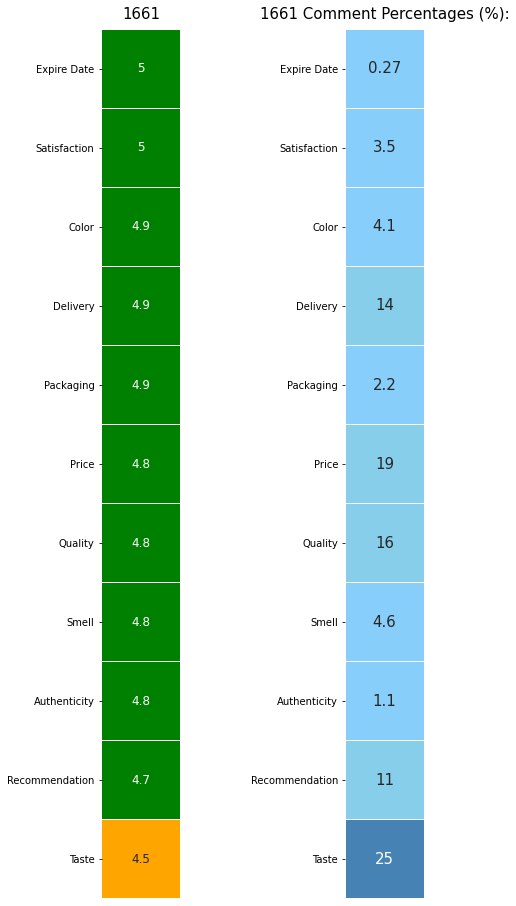

1778 - Avg. Score: 4.77
1778 Total Comments: 187


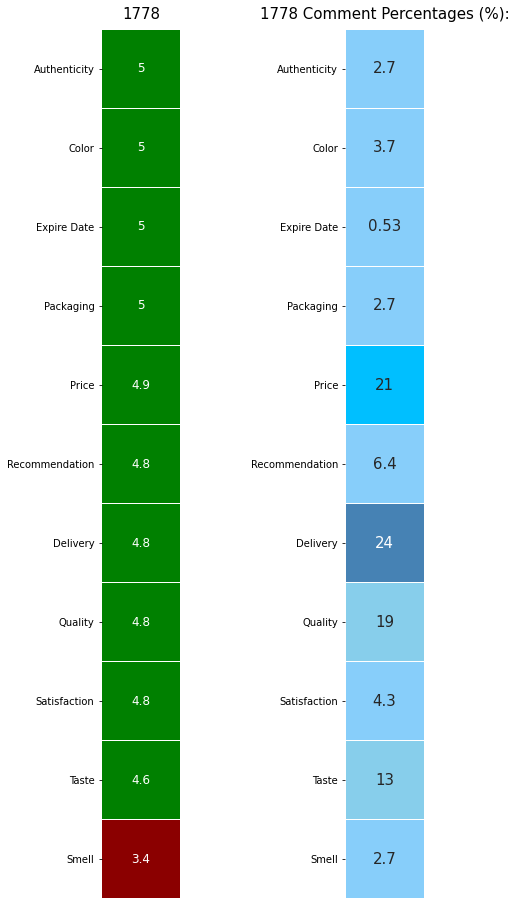

1643 - Avg. Score: 4.81
1643 Total Comments: 302


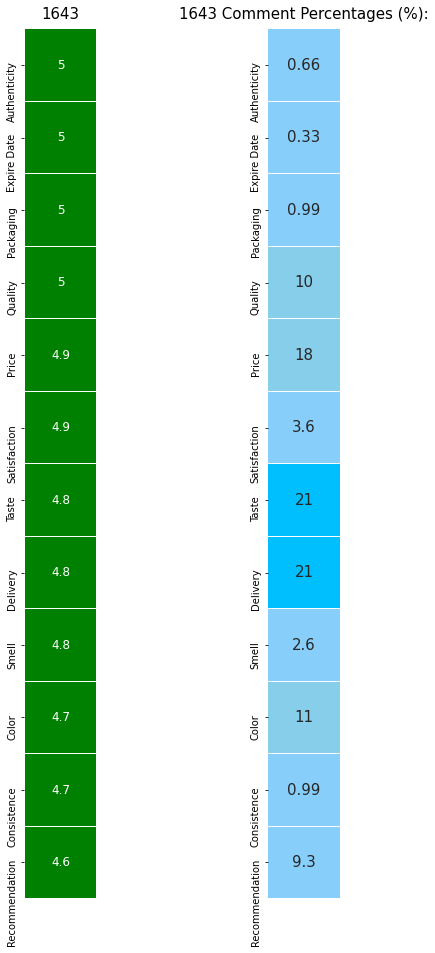

1529 - Avg. Score: 4.58
1529 Total Comments: 177


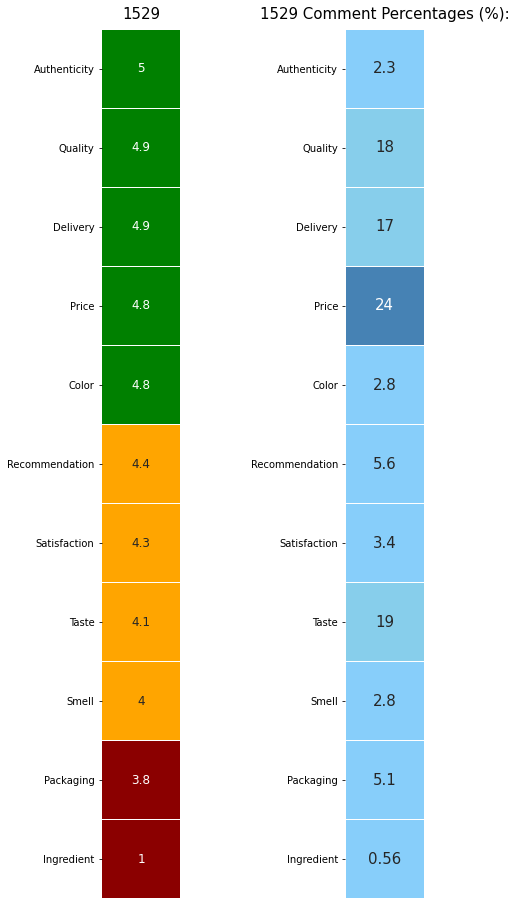

In [78]:
for sku in ul_sku500:
    single_heatmap(attr_df, mode="SKU", name=sku, vertical=True, annot=True, all_categs=False)